In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/DATASET-balanced.csv
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-Obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/margot-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/linus-to-obama.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/taylor-to-biden.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/musk-to-trump.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/ryan-to-musk.wav
/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/trump-to-musk.wav
/kaggle/input/deep-voice-deepfake-

# Import Libraries

Dataset :https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition

In [2]:
!pip install resampy

  Obtaining dependency information for resampy from https://files.pythonhosted.org/packages/4d/b9/3b00ac340a1aab3389ebcc52c779914a44aadf7b0cb7a3bf053195735607/resampy-0.4.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 42.9 MB/s eta 0:00:0000:0100:01


In [3]:
import numpy as np
import pandas as pd
import os
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import IPython
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Load Data

In [4]:
audio_files_path = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/"

In [5]:
folders = os.listdir(audio_files_path)
print(folders)

['FAKE', 'REAL']


In [6]:
real_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/kaggle/input/deep-voice-deepfake-voice-recognition/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

# Visualization

In [7]:
print("Real Audio:")
IPython.display.Audio(real_audio)

Real Audio:


In [8]:
print("Fake Audio:")
IPython.display.Audio(fake_audio)

Fake Audio:


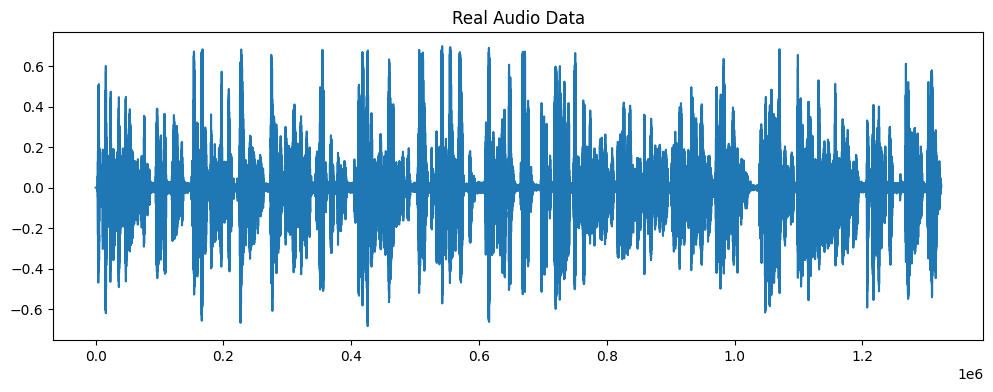

In [9]:
real_ad, real_sr = librosa.load(real_audio)
plt.figure(figsize=(12, 4))
plt.plot(real_ad)
plt.title("Real Audio Data")
plt.show()

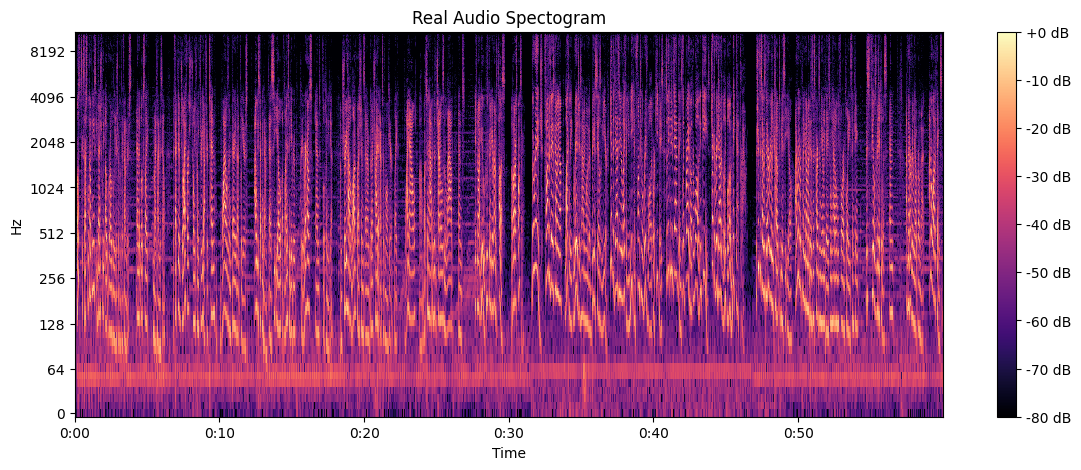

In [10]:
real_spec = np.abs(librosa.stft(real_ad))
real_spec = librosa.amplitude_to_db(real_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_spec, sr=real_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Real Audio Spectogram")
plt.show()

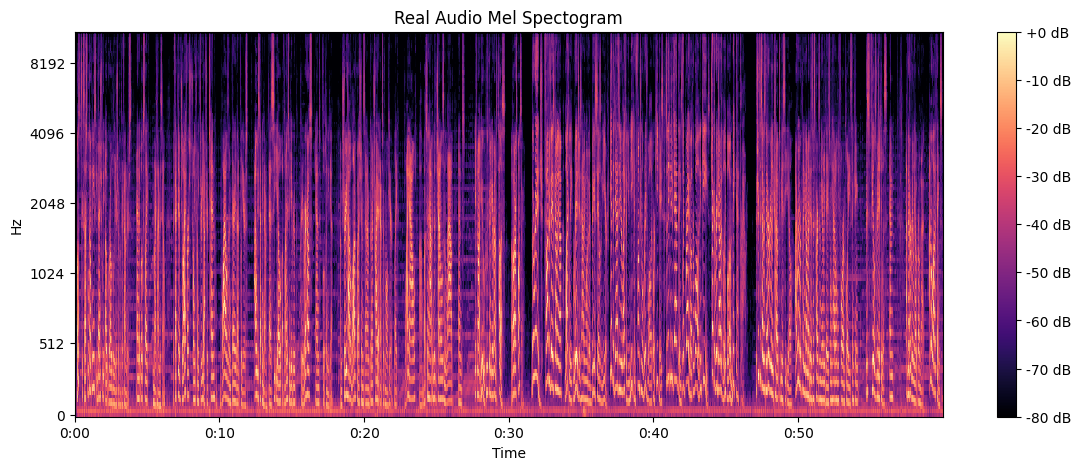

In [11]:
real_mel_spect = librosa.feature.melspectrogram(y=real_ad, sr=real_sr)
real_mel_spect = librosa.power_to_db(real_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mel_spect, y_axis="mel", x_axis="time")
plt.title("Real Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

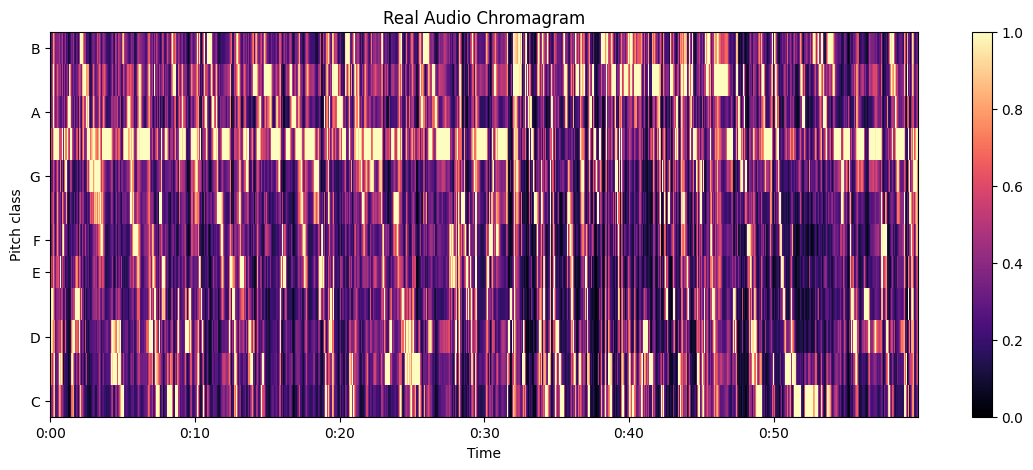

In [12]:
real_chroma = librosa.feature.chroma_cqt(y=real_ad, sr=real_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_chroma, sr=real_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Real Audio Chromagram")
plt.show()

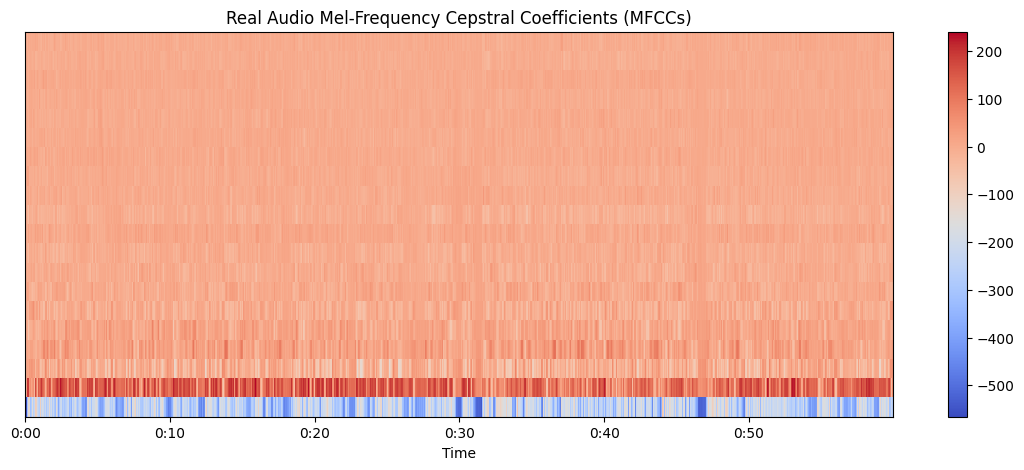

In [13]:
real_mfccs = librosa.feature.mfcc(y=real_ad, sr=real_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(real_mfccs, sr=real_sr, x_axis="time")
plt.colorbar()
plt.title("Real Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

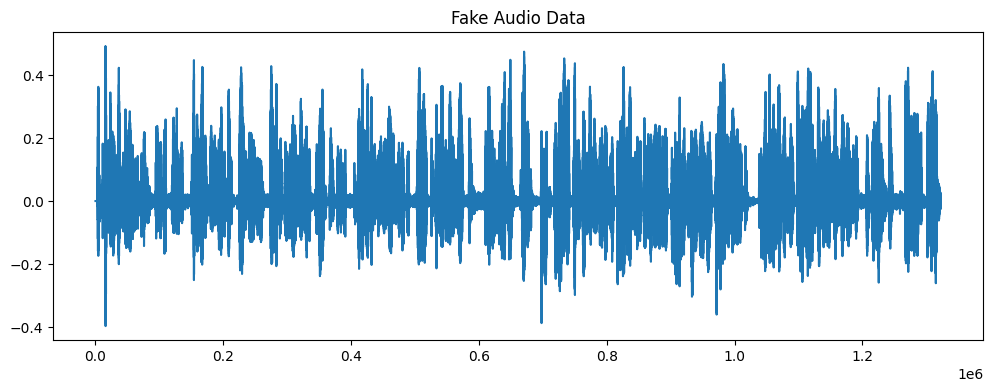

In [14]:
fake_ad, fake_sr = librosa.load(fake_audio)
plt.figure(figsize=(12, 4))
plt.plot(fake_ad)
plt.title("Fake Audio Data")
plt.show()

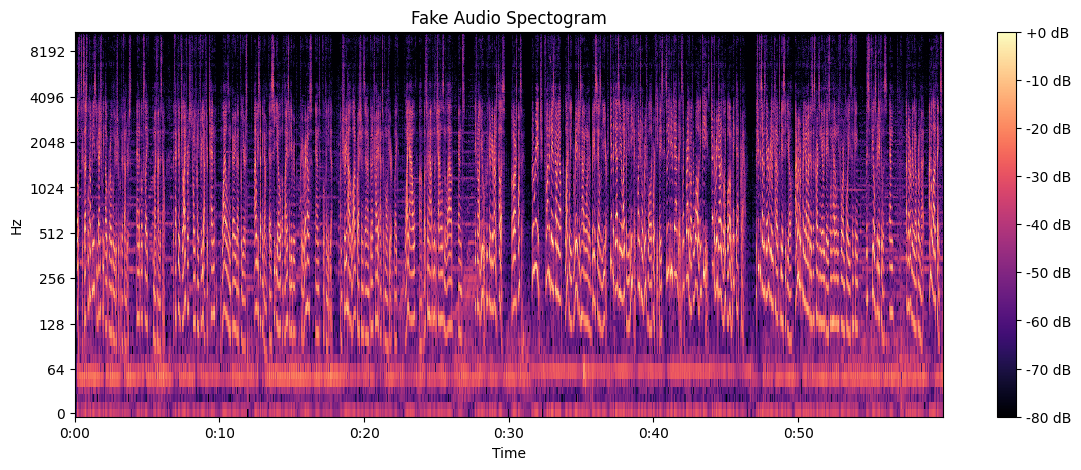

In [15]:
fake_spec = np.abs(librosa.stft(fake_ad))
fake_spec = librosa.amplitude_to_db(fake_spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_spec, sr=fake_sr, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.0f dB")
plt.title("Fake Audio Spectogram")
plt.show()

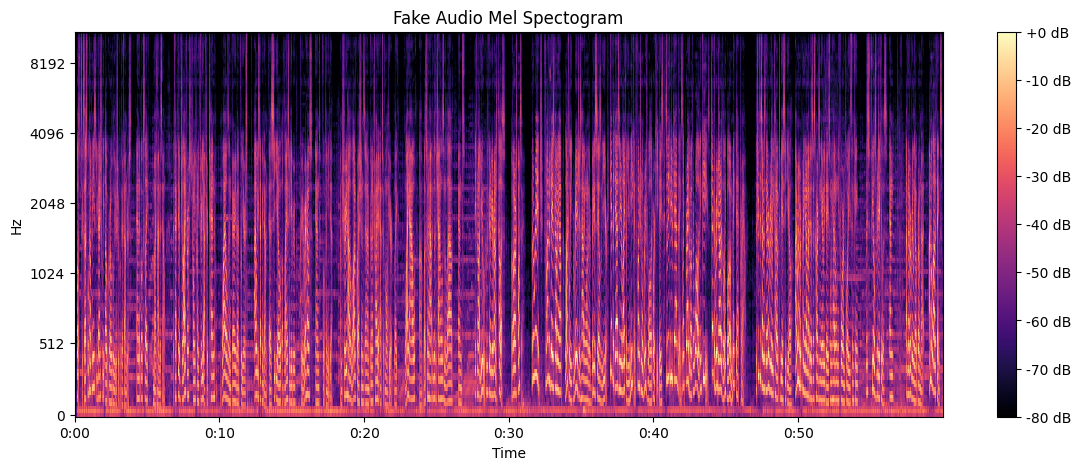

In [16]:
fake_mel_spect = librosa.feature.melspectrogram(y=fake_ad, sr=fake_sr)
fake_mel_spect = librosa.power_to_db(fake_mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mel_spect, y_axis="mel", x_axis="time")
plt.title("Fake Audio Mel Spectogram")
plt.colorbar(format="%+2.0f dB")
plt.show()

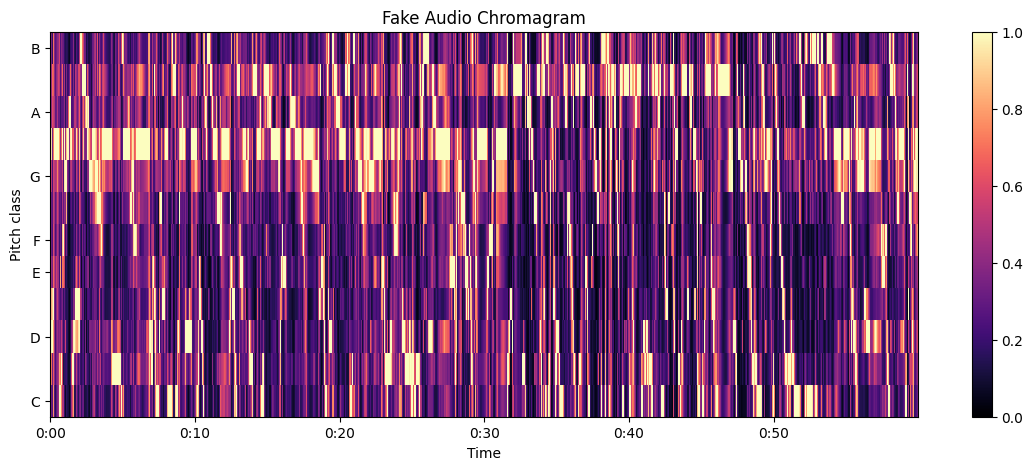

In [17]:
fake_chroma = librosa.feature.chroma_cqt(y=fake_ad, sr=fake_sr, bins_per_octave=36)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_chroma, sr=fake_sr, x_axis="time", y_axis="chroma", vmin=0, vmax=1)
plt.colorbar()
plt.title("Fake Audio Chromagram")
plt.show()

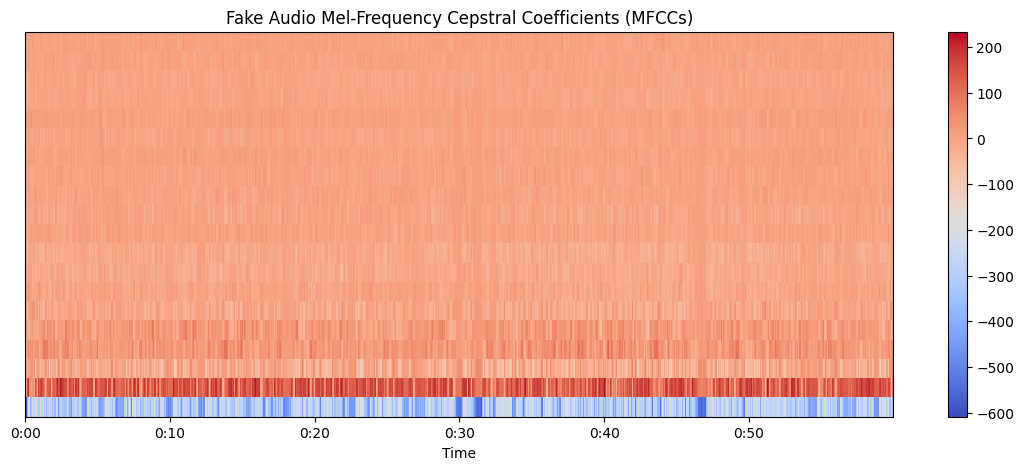

In [18]:
fake_mfccs = librosa.feature.mfcc(y=fake_ad, sr=fake_sr)

plt.figure(figsize=(14, 5))
librosa.display.specshow(fake_mfccs, sr=fake_sr, x_axis="time")
plt.colorbar()
plt.title("Fake Audio Mel-Frequency Cepstral Coefficients (MFCCs)")
plt.show()

# Preprocess

In [19]:
data = []
labels = []

for folder in folders:
    files = os.listdir(os.path.join(audio_files_path, folder))
    for file in tqdm(files):
        file_path = os.path.join(audio_files_path, folder, file)
        audio, sample_rate = librosa.load(file_path, res_type="kaiser_fast")
        mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        mfccs_features_scaled = np.mean(mfccs_features.T, axis=0)
        data.append(mfccs_features_scaled)
        labels.append(folder)

100%|██████████| 8/8 [01:00<00:00,  7.52s/it]


In [20]:
feature_df = pd.DataFrame({"features": data, "class": labels})
feature_df.head()

features class
0  [-291.10123, 95.36503, -13.482852, 10.591423, ...  FAKE
1  [-250.76636, 117.728546, -22.377504, 30.396112...  FAKE
2  [-256.0186, 108.66988, 2.0284197, 24.126278, 2...  FAKE
3  [-295.43436, 76.94639, -0.6353918, 17.214228, ...  FAKE
4  [-288.0438, 75.1327, 1.3050734, 20.612984, -2....  FAKE

In [21]:
feature_df["class"].value_counts()

class
FAKE    56
REAL     8
Name: count, dtype: int64

In [22]:
def label_encoder(column):
    le = LabelEncoder().fit(column)
    print(column.name, le.classes_)
    return le.transform(column)

In [23]:
feature_df["class"] = label_encoder(feature_df["class"])

class ['FAKE' 'REAL']


# Feature Scaling

In [24]:
X = np.array(feature_df["features"].tolist())
y = np.array(feature_df["class"].tolist())

In [25]:
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

In [26]:
y_resampled = to_categorical(y_resampled)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [83]:
num_labels = len(feature_df["class"].unique())
num_labels

2

In [84]:
input_shape = feature_df["features"][0].shape
input_shape

(40,)

# Model

In [85]:
model = Sequential()
model.add(Dense(128, input_shape=input_shape))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(128))
model.add(Activation(activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(num_labels))
model.add(Activation(activation="softmax"))

In [86]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [87]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 128)               5248      
                                                                 
 activation_8 (Activation)   (None, 128)               0         
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 activation_9 (Activation)   (None, 256)               0         
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 128)              

In [88]:
early = EarlyStopping(monitor="val_loss", patience=5)

In [96]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=2, epochs=100 )

Epoch 1/100
45/45 [==============================] - 0s 5ms/step - loss: 1.4229 - accuracy: 0.4494 - val_loss: 0.6756 - val_accuracy: 0.6522
Epoch 2/100
45/45 [==============================] - 0s 4ms/step - loss: 1.7544 - accuracy: 0.4494 - val_loss: 0.6826 - val_accuracy: 0.6957
Epoch 3/100
45/45 [==============================] - 0s 4ms/step - loss: 1.0440 - accuracy: 0.5393 - val_loss: 0.6924 - val_accuracy: 0.4783
Epoch 4/100
45/45 [==============================] - 0s 4ms/step - loss: 1.2749 - accuracy: 0.4607 - val_loss: 0.6887 - val_accuracy: 0.6957
Epoch 5/100
45/45 [==============================] - 0s 4ms/step - loss: 0.9719 - accuracy: 0.5393 - val_loss: 0.6864 - val_accuracy: 0.6087
Epoch 6/100
45/45 [==============================] - 0s 4ms/step - loss: 1.0607 - accuracy: 0.4719 - val_loss: 0.6883 - val_accuracy: 0.6522
Epoch 7/100
45/45 [==============================] - 0s 4ms/step - loss: 1.1273 - accuracy: 0.5618 - val_loss: 0.6856 - val_accuracy: 0.6522
Epoch 8/100
4

In [97]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

1/1 [==============================] - 0s 22ms/step - loss: 0.4753 - accuracy: 0.8261
Test Loss: 0.4752989113330841
Test Accuracy: 0.8260869383811951


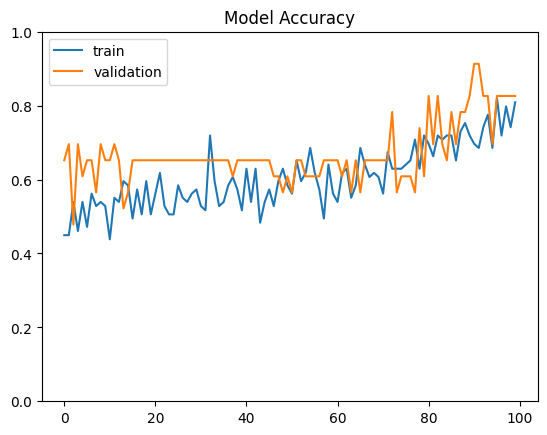

In [98]:
plt.figure()
plt.title("Model Accuracy")
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

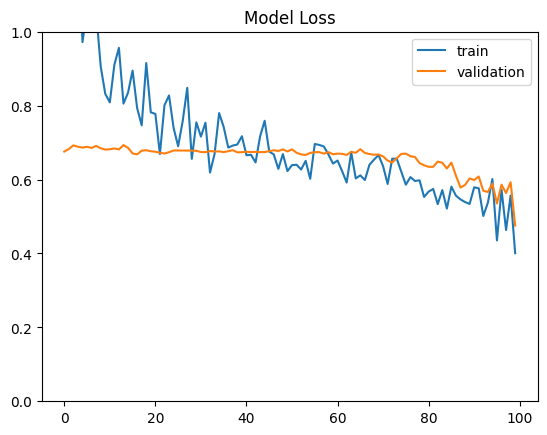

In [99]:
plt.figure()
plt.title("Model Loss")
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="validation")
plt.legend()
plt.ylim([0, 1])
plt.show()

# Test

In [100]:
def detect_fake(filename):
    sound_signal, sample_rate = librosa.load(filename, res_type="kaiser_fast")
    mfcc_features = librosa.feature.mfcc(y=sound_signal, sr=sample_rate, n_mfcc=40)
    mfccs_features_scaled = np.mean(mfcc_features.T, axis=0)
    mfccs_features_scaled = mfccs_features_scaled.reshape(1, -1)
    result_array = model.predict(mfccs_features_scaled)
    print(result_array)
    result_classes = ["FAKE", "REAL"]
    result = np.argmax(result_array[0])
    print("Result:", result_classes[result])

In [104]:
test_real = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/REAL/obama-original.wav"
test_fake = "/kaggle/input/deep-voice-deepfake-voice-recognition/KAGGLE/AUDIO/FAKE/obama-to-taylor.wav"

In [105]:
detect_fake(test_real)

1/1 [==============================] - 0s 31ms/step
[[0.30944172 0.6905583 ]]
Result: REAL


In [106]:
detect_fake(test_fake)

1/1 [==============================] - 0s 34ms/step
[[0.69682753 0.3031725 ]]
Result: FAKE
